In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join("..")))

In [3]:
import wandb
import pandas as pd
import pytorch_lightning as pl
import torch
import numpy as np
from pathlib import Path
from src.utils.io import HDFReader
from src.data.preprocess import preprocess
from src.data.modules.paralog import ParalogousGeneDataModule
from src.models.baseline import ConvolutionalModel
from pytorch_lightning.loggers import WandbLogger

In [4]:
# preprocess(
#     "data/genome/gff_file.gff",
#     "data/genome/fasta_file.fsa",
#     "data/embeddings",
#     "data/waern_2013",
#     "data/samples.json",
#     "data/processed",
#     500,
# )

In [5]:
summary_path = Path("../data/processed/summary.csv")
h5_path = Path("../data/processed/genewise.h5")

assert summary_path.exists()
assert h5_path.exists()

In [6]:
h5_reader = HDFReader("../data/processed/genewise.h5")

In [7]:
genes = pd.read_csv(summary_path)["gene"].to_list()
genes[:5]

['YAL001C', 'YAL002W', 'YAL003W', 'YAL004W', 'YAL005C']

In [8]:
# gene_expression = {
#     gene: h5_reader[gene][1] for gene in genes
# }
# df_expression = pd.DataFrame(gene_expression).T


In [9]:
df_summary = pd.read_csv(summary_path)
df_summary.head()

,gene,coordinates,chromosome,strand,paralog_group
0,YAL001C,"[(147594, 151006), (151097, 151166)]",chrI,-,YAL001C
1,YAL002W,"[(143707, 147531)]",chrI,+,YAL002W
2,YAL003W,"[(142174, 142253), (142620, 143160)]",chrI,+,YAL003W
3,YAL004W,"[(140760, 141407)]",chrI,+,YAL004W
4,YAL005C,"[(139503, 141431)]",chrI,-,YKL073W


In [10]:
df_summary_subset = df_summary.sample(1000)

In [18]:
from pathlib import Path
import torch
import pytorch_lightning as pl

# --- config (match your training setup) ---
lr = 1e-3
batch_size = 8
weight_decay = 1e-4
pooling_type = "max"
average_window = False
n_folds = 5

model_output_dir = Path("../models/baseline")

for fold in range(n_folds):
    # --- prepare test data ---
    dm = ParalogousGeneDataModule(
        HDFReader("../data/processed/genewise.h5"),
        df_summary,
        fold,
        batch_size=batch_size,
        prefetch_factor=20,
        n_folds=n_folds,
    )
    test_loader = dm.test_dataloader()

    # --- build model ---
    model = ConvolutionalModel(
        pooling_type=pooling_type,
        learning_rate=lr,
        weight_decay=weight_decay,
        average_window=average_window,
    )

    # --- load weights ---
    model_path = model_output_dir / f"fold_{fold}.pth"
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()

    # get conv kernel weight (assuming it's the first conv layer)
    kernel_weight = model.conv.weight.detach().cpu().numpy().squeeze(-1)  # shape: (768, 18)

    # save as .npy
    np.save(model_output_dir / f"fold_{fold}_conv_weights.npy", kernel_weight)




    # --- run test ---
    trainer = pl.Trainer(logger=False, enable_model_summary=False)
    test_metrics = trainer.test(model, dataloaders=test_loader)
    print(f"Fold {fold} | Test Metrics: {test_metrics}")


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no a

LOGGING MAX POSITIONS   0%|                                                                    | 0/164 [00:00<?, ?it/s]
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS   2%|█                                                           | 3/164 [00:00<00:10, 15.36it/s]
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS   3%|█▊                                                          | 5/164 [00:00<00:11, 13.35it/s]
HELLO
LOGGING MAX POSITIONS   4%|██▏                                                         | 6/164 [00:00<00:12, 13.01it/s]
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS   7%|███▉                                                       | 11/164 [00:00<00:12, 12.00it/s]
HELLO
LOGGING MAX POSITIONS   7%|████▎                                                      | 12/164 [00:01<00:12, 11.99it/s]
HELLO
LOGGING MAX POSITIONS   8%|████▋                

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no a

LOGGING MAX POSITIONS   0%|                                                                    | 0/161 [00:00<?, ?it/s]
HELLO
LOGGING MAX POSITIONS   1%|▎                                                           | 1/161 [00:00<00:03, 47.62it/s]
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS   2%|█                                                           | 3/161 [00:00<00:10, 14.99it/s]
HELLO
LOGGING MAX POSITIONS   2%|█▍                                                          | 4/161 [00:00<00:11, 14.20it/s]
HELLO
LOGGING MAX POSITIONS   3%|█▊                                                          | 5/161 [00:00<00:11, 13.60it/s]
HELLO
LOGGING MAX POSITIONS   4%|██▏                                                         | 6/161 [00:00<00:11, 13.16it/s]
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS   5%|██▉                                                         | 8/161 [00:00<00:12, 12.63it/s]
HELLO
LOGGING MAX POSITIONS   6%|███▎                               

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no a

LOGGING MAX POSITIONS   0%|                                                                    | 0/173 [00:00<?, ?it/s]
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS   1%|▋                                                           | 2/173 [00:00<00:10, 16.69it/s]
HELLO
LOGGING MAX POSITIONS   2%|█                                                           | 3/173 [00:00<00:13, 12.43it/s]
HELLO
LOGGING MAX POSITIONS   2%|█▍                                                          | 4/173 [00:00<00:16, 10.10it/s]
HELLO
LOGGING MAX POSITIONS   3%|█▋                                                          | 5/173 [00:00<00:18,  9.24it/s]
HELLO
LOGGING MAX POSITIONS   3%|██                                                          | 6/173 [00:00<00:19,  8.58it/s]
HELLO
LOGGING MAX POSITIONS   4%|██▍                                                         | 7/173 [00:00<00:19,  8.50it/s]
HELLO
LOGGING MAX POSITIONS   5%|██▊                                                         | 8

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no a

LOGGING MAX POSITIONS   0%|                                                                    | 0/178 [00:00<?, ?it/s]
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS   1%|▋                                                           | 2/178 [00:00<00:18,  9.32it/s]
HELLO
LOGGING MAX POSITIONS   2%|█                                                           | 3/178 [00:00<00:20,  8.69it/s]
HELLO
LOGGING MAX POSITIONS   2%|█▎                                                          | 4/178 [00:00<00:20,  8.65it/s]
HELLO
LOGGING MAX POSITIONS   3%|█▋                                                          | 5/178 [00:00<00:20,  8.50it/s]
HELLO
LOGGING MAX POSITIONS   3%|██                                                          | 6/178 [00:00<00:21,  8.14it/s]
HELLO
LOGGING MAX POSITIONS   4%|██▎                                                         | 7/178 [00:00<00:21,  7.87it/s]
HELLO
LOGGING MAX POSITIONS   4%|██▋                                                         | 8

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\49176\anaconda3\envs\single_cell\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no a

LOGGING MAX POSITIONS   0%|                                                                    | 0/164 [00:00<?, ?it/s]
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS   1%|▋                                                           | 2/164 [00:00<00:09, 17.31it/s]
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS   3%|█▊                                                          | 5/164 [00:00<00:12, 12.28it/s]
HELLO
LOGGING MAX POSITIONS   4%|██▏                                                         | 6/164 [00:00<00:13, 12.07it/s]
HELLO
LOGGING MAX POSITIONS
HELLO
LOGGING MAX POSITIONS   5%|██▉                                                         | 8/164 [00:00<00:13, 11.83it/s]
HELLO
LOGGING MAX POSITIONS   5%|███▎                                                        | 9/164 [00:00<00:13, 11.82it/s]
HELLO
LOGGING MAX POSITIONS   6%|███▌                                                       | 10/164 [00:00<00:12, 11.86it/s]
HELLO
LOGGIN

(18, 768)


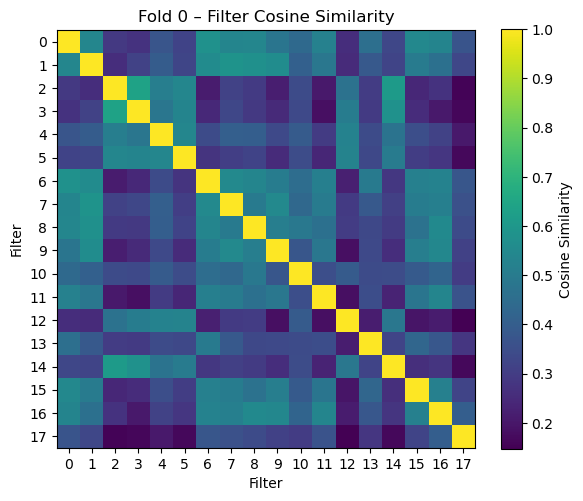

(18, 768)


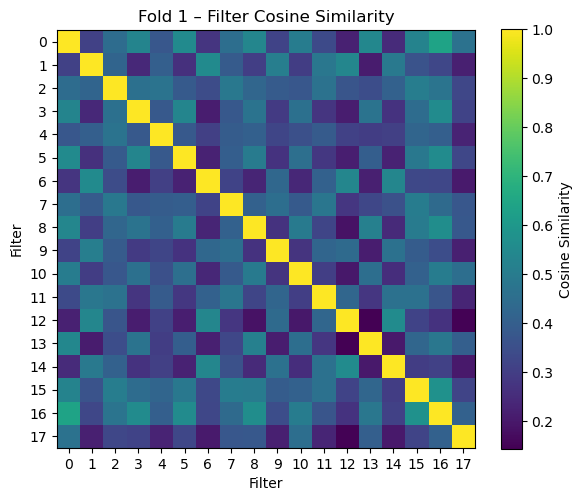

(18, 768)


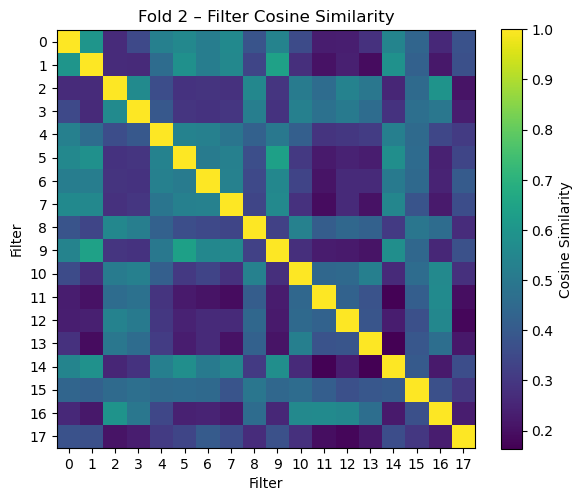

(18, 768)


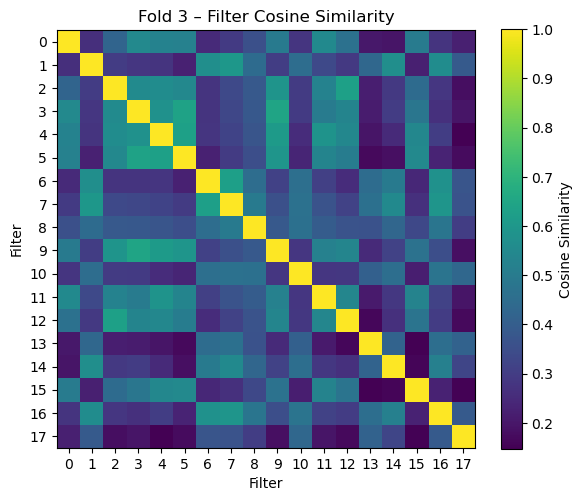

(18, 768)


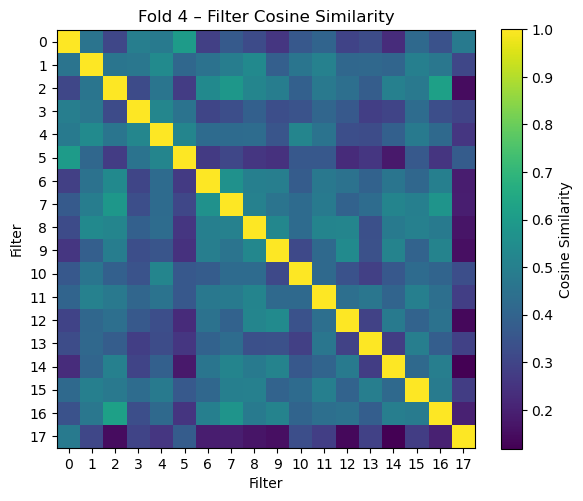

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path

model_output_dir = Path("../models/baseline")
n_folds = 5

for fold in range(n_folds):
    # Load weights: shape (768, 18)
    weights = np.load(model_output_dir / f"fold_{fold}_conv_weights.npy")
    print(weights.shape)

    # Compute cosine similarity between all 18 filters
    similarity_matrix = cosine_similarity(weights)

    # Plot heatmap
    plt.figure(figsize=(6, 5))
    plt.imshow(similarity_matrix, cmap='viridis')
    plt.colorbar(label='Cosine Similarity')
    plt.title(f'Fold {fold} – Filter Cosine Similarity')
    plt.xlabel('Filter')
    plt.ylabel('Filter')
    plt.xticks(range(18))
    plt.yticks(range(18))
    plt.tight_layout()
    plt.show()
